In [1]:
using Plots
using LinearAlgebra
using Parameters
using StaticArrays

In [2]:
module My

using Parameters
using StaticArrays

@with_kw struct PhysicalParam{T₁, T₂, T₃} @deftype Float64 
    ħc = 200 # [MeV fm]
    mc² = 1000 # [MeV]
    M = ħc^2/2mc² # [MeV fm²]
    
    U₀ = -55 # [MeV]
    V₀ = -3 # [MeV]
    r₀ = 5 # [fm]
    λ = -8 # [MeV]
    
    Nr::Int64 = 100
    Δr = 0.1 # [fm]
    rs::T₁ = range(0, Nr*Δr, length=Nr+1)
    
    ir_matching::Int64 = floor(Int, r₀/Δr) + 1
    
    ys_1p::T₂ = zeros(Float64, 2, Nr+1)
    ys_2p::T₂ = zeros(Float64, 2, Nr+1)
    ys_1m::T₂ = zeros(Float64, 2, Nr+1)
    ys_2m::T₂ = zeros(Float64, 2, Nr+1)
    
    Gs::T₂ = zeros(Float64, 2, Nr+1)
    
    As::T₃     = zeros(Float64, 2, 2, Nr+1)
    As_inv::T₃ = zeros(Float64, 2, 2, Nr+1)
    
    # matching matrix
    M₄::Matrix{Float64} = zeros(Float64, 4, 4)
end

end # module My

Main.My

In [10]:
param = My.PhysicalParam()

Main.My.PhysicalParam{StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}, Matrix{Float64}, Array{Float64, 3}}
  ħc: Float64 200.0
  mc²: Float64 1000.0
  M: Float64 20.0
  U₀: Float64 -55.0
  V₀: Float64 -3.0
  r₀: Float64 5.0
  λ: Float64 -8.0
  Nr: Int64 100
  Δr: Float64 0.1
  rs: StepRangeLen{Float64, Base.TwicePrecision{Float64}, Base.TwicePrecision{Float64}, Int64}
  ir_matching: Int64 51
  ys_1p: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  ys_2p: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  ys_1m: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  ys_2m: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  Gs: Array{Float64}((2, 101)) [0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0]
  As: Array{Float64}((2, 2, 101)) [0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; … ;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0;;; 0.0 0.0; 0.0 0.0]
  As_inv: Array{Float64}((2, 2, 101)) [0.0 

In [115]:
function inv2!(A_inv, A)
    d = A[1,1]*A[2,2] - A[1,2]*A[2,1]
    
    A_inv[1,1] = A[2,2]/d
    A_inv[1,2] = -A[1,2]/d
    A_inv[2,1] = -A[2,1]/d
    A_inv[2,2] = A[1,1]/d
end

function normalize!(ys, rs)
    Δr = rs[2]-rs[1]
    norm = 0.0
    for ir in 1:length(rs)
        norm += ys[1,ir]^2 + ys[2,ir]^2
    end
    @. ys /= norm
    return 
end

function integrate_HFBeq!(ys, param, E; direction=:outward)
    @unpack M, U₀, V₀, λ, 
        Nr, Δr, rs, ir_matching, 
        Gs, As, As_inv = param 
    
    @views if direction === :outward
        for ir in 1:Nr+1
            As[1,1,ir] = 1 - (Δr*Δr/12)*(U₀-λ-E)/M
            As[2,2,ir] = 1 - (Δr*Δr/12)*(U₀-λ+E)/M 
            
            As[1,2,ir] = - (Δr*Δr/12)*V₀/M
            As[2,1,ir] =   (Δr*Δr/12)*V₀/M
            
            inv2!(As_inv[:,:,ir], As[:,:,ir])
        end
        
        mul!(Gs[:,1], As[:,:,1], ys[:,1])
        mul!(Gs[:,2], As[:,:,2], ys[:,2])
        for ir in 3:Nr+1
            @. Gs[:,ir] = 12ys[:,ir-1] - 10*Gs[:,ir-1] - Gs[:,ir-2]
            mul!(ys[:,ir], As_inv[:,:,ir], Gs[:,ir])
        end
    end
    
    @views if direction === :inward
        for ir in Nr+1: -1: 1
            As[1,1,ir] = 1 - (Δr*Δr/12)*(-λ-E)/M
            As[2,2,ir] = 1 - (Δr*Δr/12)*(-λ+E)/M 
            
            As[1,2,ir] = 0
            As[2,1,ir] = 0
            
            inv2!(As_inv[:,:,ir], As[:,:,ir])
        end
        
        mul!(Gs[:,Nr+1], As[:,:,Nr+1], ys[:,Nr+1])
        mul!(Gs[:,Nr  ], As[:,:,Nr  ], ys[:,Nr  ])
        for ir in Nr-1: -1: 1
            @. Gs[:,ir] = 12ys[:,ir+1] - 10*Gs[:,ir+1] - Gs[:,ir+2]
            mul!(ys[:,ir], As_inv[:,:,ir], Gs[:,ir])
        end
    end
    
    #normalize!(ys, rs)
    
    return 
end

function test_integrate_HFBeq!(param; E=5.6)
    @unpack rs, Nr, Δr, ys_1p, ys_2p, ys_1m, ys_2m = param
    
    ys_1p[1,1] = 0
    ys_1p[2,1] = 0
    ys_1p[1,2] = Δr
    ys_1p[2,2] = 0
    
    @time integrate_HFBeq!(ys_1p, param, E)
    p = plot()
    plot!(rs, param.ys_1p[1,:]; label="1+")
    plot!(rs, param.ys_1p[2,:]; label="1+")
    display(p)
    
    
    ys_2p[1,1] = 0
    ys_2p[2,1] = 0
    ys_2p[1,2] = 0
    ys_2p[2,2] = Δr
    
    @time integrate_HFBeq!(ys_2p, param, E)
    p = plot()
    plot!(rs, ys_2p[1,:]; label="2+")
    plot!(rs, ys_2p[2,:]; label="2+")
    display(p)
    
    
    ys_1m[1,Nr+1] = 0
    ys_1m[2,Nr+1] = 0
    ys_1m[1,Nr  ] = Δr
    ys_1m[2,Nr  ] = 0
    
    @time integrate_HFBeq!(ys_1m, param, E; direction = :inward)
    p = plot()
    plot!(rs, ys_1m[1,:]; label="1-")
    plot!(rs, ys_1m[2,:]; label="1-")
    display(p)
    
    
    ys_2m[1,Nr+1] = 0
    ys_2m[2,Nr+1] = 0
    ys_2m[1,Nr  ] = 0
    ys_2m[2,Nr  ] = Δr
    
    @time integrate_HFBeq!(ys_2m, param, E; direction = :inward)
    p = plot()
    plot!(rs, param.ys_2m[1,:]; label="2-")
    plot!(rs, param.ys_2m[2,:]; label="2-")
    display(p)
end

test_integrate_HFBeq! (generic function with 1 method)

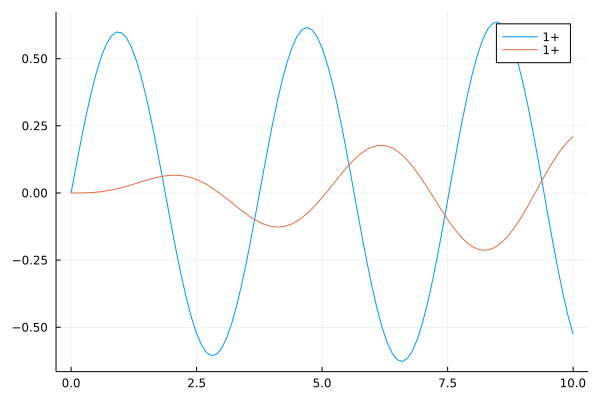

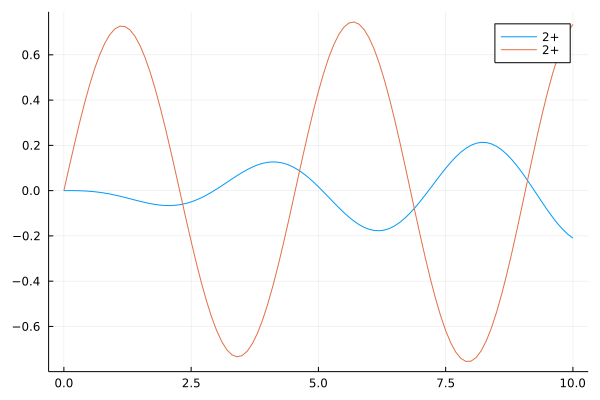

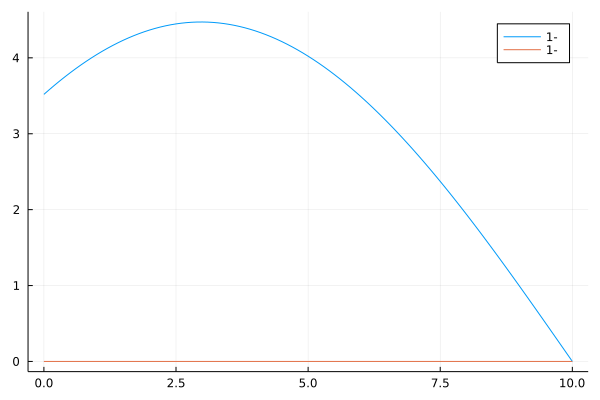

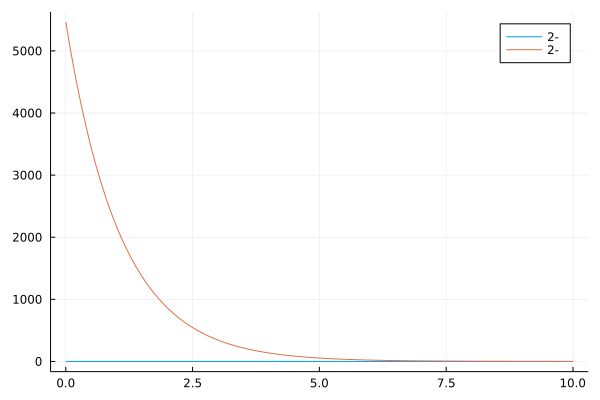

  0.000008 seconds
  0.000007 seconds
  0.000008 seconds
  0.000011 seconds


In [116]:
test_integrate_HFBeq!(param; E = 9)

In [120]:
function calc_matching_matrix!(param)
    @unpack Δr, ir_matching, ys_1p, ys_2p, ys_1m, ys_2m, M₄ = param
    
    ir = ir_matching
    
    #=
    ratio = ys_1p[2,ir]/ys_1m[2,ir]
    @views @. ys_1m *= ratio
    =#
    
    ratio = ys_2p[2,ir]/ys_2m[2,ir]
    @views @. ys_2m *= ratio
    
    M₄[1,1] =  ys_1p[1,ir]
    M₄[1,2] =  ys_2p[1,ir]
    M₄[1,3] = -ys_1m[1,ir]
    M₄[1,4] = -ys_2m[1,ir]
    
    M₄[2,1] =  ys_1p[2,ir]
    M₄[2,2] =  ys_2p[2,ir]
    M₄[2,3] = -ys_1m[2,ir]
    M₄[2,4] = -ys_2m[2,ir]
    
    M₄[3,1] =  (ys_1p[1,ir+1] - ys_1p[1,ir-1])/2Δr
    M₄[3,2] =  (ys_2p[1,ir+1] - ys_2p[1,ir-1])/2Δr
    M₄[3,3] = -(ys_1m[1,ir+1] - ys_1m[1,ir-1])/2Δr
    M₄[3,4] = -(ys_2m[1,ir+1] - ys_2m[1,ir-1])/2Δr
    
    M₄[4,1] =  (ys_1p[2,ir+1] - ys_1p[2,ir-1])/2Δr
    M₄[4,2] =  (ys_2p[2,ir+1] - ys_2p[2,ir-1])/2Δr
    M₄[4,3] = -(ys_1m[2,ir+1] - ys_1m[2,ir-1])/2Δr
    M₄[4,4] = -(ys_2m[2,ir+1] - ys_2m[2,ir-1])/2Δr
    
    return 
end

function test_calc_matching_matrix!(param, Es)
    @unpack Nr, Δr, ys_1p, ys_2p, ys_1m, ys_2m, M₄ = param
    
    dets = similar(Es)
    
    for iE in 1:length(Es)
        ys_1p[1,1] = 0
        ys_1p[2,1] = 0
        ys_1p[1,2] = Δr
        ys_1p[2,2] = 0
        integrate_HFBeq!(ys_1p, param, Es[iE])

        ys_2p[1,1] = 0
        ys_2p[2,1] = 0
        ys_2p[1,2] = 0
        ys_2p[2,2] = Δr
        integrate_HFBeq!(ys_2p, param, Es[iE])
        
        ys_1m[1,Nr+1] = 0
        ys_1m[2,Nr+1] = 0
        ys_1m[1,Nr  ] = Δr
        ys_1m[2,Nr  ] = 0
        integrate_HFBeq!(ys_1m, param, Es[iE]; direction = :inward)

        ys_2m[1,Nr+1] = 0
        ys_2m[2,Nr+1] = 0
        ys_2m[1,Nr  ] = 0
        ys_2m[2,Nr  ] = Δr
        integrate_HFBeq!(ys_2m, param, Es[iE]; direction = :inward)
        
        calc_matching_matrix!(param)
        
        dets[iE] = det(M₄)
    end
    return dets
end

test_calc_matching_matrix! (generic function with 1 method)

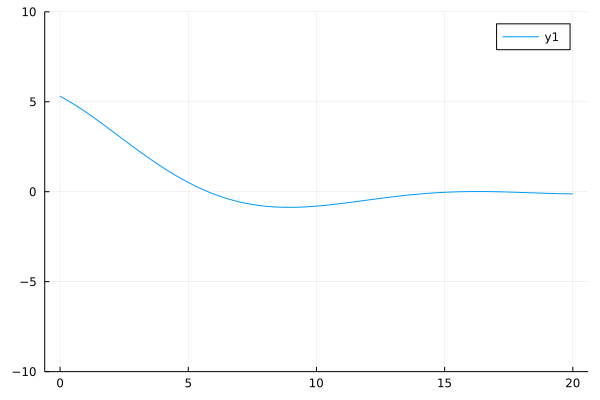

In [123]:
param = My.PhysicalParam(V₀ = -3, Nr=100)
Es = 0:0.1:20
dets = test_calc_matching_matrix!(param, Es)
plot(Es, dets; ylim=(-10, 10))